<a href="https://colab.research.google.com/github/thetrotfreak/MCA572/blob/main/2347111_NNDL_ETE_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MCA527

> ETE 3
>
> Bivas Kumar
>
> 2347111

# Load the Dataset

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import numpy as np
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Trimester/5/nndl/weather_data.csv")

In [53]:
df.head()

,date,temperature
0,2014-01-01,10.248357
1,2014-01-02,9.950428
2,2014-01-03,10.362958
3,2014-01-04,10.820167
4,2014-01-05,9.961091


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2557 non-null   object 
 1   temperature  2557 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.1+ KB


In [55]:
df.describe()

,temperature
count,2557.000000
mean,10.017472
std,0.923047
min,3.337291
25%,9.335195
50%,10.031778
75%,10.681384
max,15.587945


# Preprocess the Dataset

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

data = df
data['date'] = pd.to_datetime(df['date'])
data.set_index('date', inplace=True)

# Normalize the temperature data
scaler = MinMaxScaler()
data['temperature'] = scaler.fit_transform(data[['temperature']])

# Split into training and testing sets
train_data, test_data = train_test_split(data['temperature'], test_size=0.2, shuffle=False)
train_data = np.array(train_data).reshape(-1, 1)
test_data = np.array(test_data).reshape(-1, 1)

# Function to create sequences of data for LSTM input
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

# Sequence length for input
seq_length = 30

# Prepare training sequences
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Build an LSTM Autoencoder

In [57]:
from keras.models import Model, Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input

# Define the LSTM Autoencoder
model = Sequential([
    Input(shape=(seq_length, 1)),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(seq_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')

# Train the model

In [58]:
# Train the autoencoder
history = model.fit(X_train, X_train, epochs=20, batch_size=32, validation_split=0.1, verbose=2)

Epoch 1/20
57/57 - 10s - 173ms/step - loss: 0.0988 - val_loss: 0.0296
Epoch 2/20
57/57 - 3s - 46ms/step - loss: 0.0185 - val_loss: 0.0081
Epoch 3/20
57/57 - 5s - 88ms/step - loss: 0.0131 - val_loss: 0.0086
Epoch 4/20
57/57 - 2s - 43ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 5/20
57/57 - 4s - 67ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 6/20
57/57 - 4s - 67ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 7/20
57/57 - 3s - 46ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 8/20
57/57 - 2s - 44ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 9/20
57/57 - 3s - 51ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 10/20
57/57 - 5s - 81ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 11/20
57/57 - 3s - 48ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 12/20
57/57 - 2s - 40ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 13/20
57/57 - 3s - 46ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 14/20
57/57 - 5s - 90ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 15/20
57/57 - 2s - 42ms/step - loss

# Anomaly Detection

In [59]:
# Calculate reconstruction error on the test set
reconstructions = model.predict(X_test)
reconstruction_loss = np.mean(np.abs(reconstructions - X_test), axis=1)

# Define a threshold for anomaly detection
# Set threshold as 95th percentile
threshold = np.percentile(reconstruction_loss, 95)
anomalies = reconstruction_loss > threshold

# Get dates for anomalies
anomalous_indices = np.where(anomalies)[0]
anomalous_dates = data.iloc[seq_length:seq_length + len(reconstruction_loss)].iloc[anomalous_indices].index

print(f"Anomalies detected on: {anomalous_dates}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Anomalies detected on: DatetimeIndex(['2014-08-28', '2014-08-31', '2014-09-01', '2014-09-04',
               '2014-09-06', '2014-09-07', '2014-09-08', '2014-09-09',
               '2014-09-10', '2014-09-11', '2014-09-12', '2014-09-13',
               '2014-09-14', '2014-09-15', '2014-09-16', '2014-09-17',
               '2014-09-18', '2014-09-19', '2014-09-20', '2014-09-21',
               '2014-09-22', '2014-09-23', '2014-09-24', '2014-09-25',
               '2014-09-26'],
              dtype='datetime64[ns]', name='date', freq=None)


# Visualize the Results

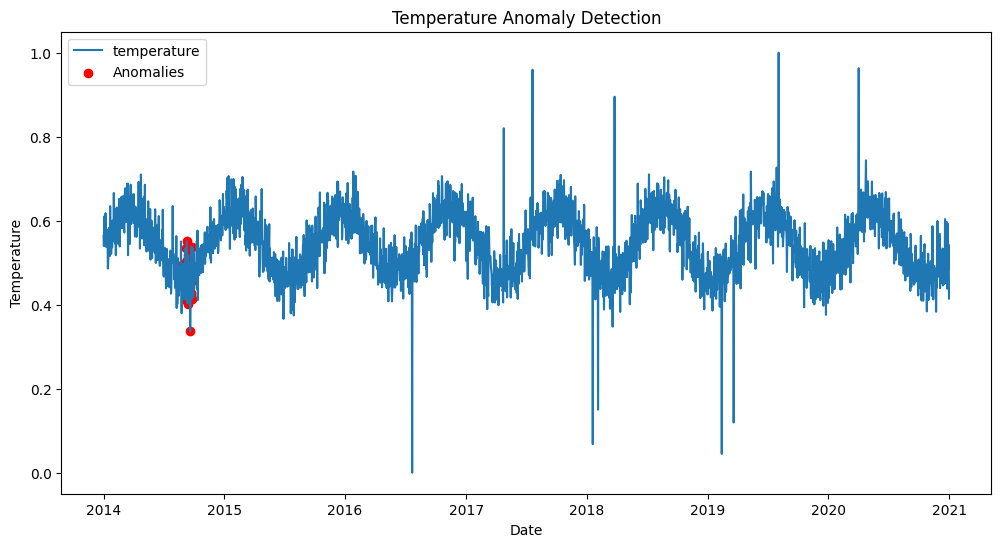

In [60]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temperature'], label='temperature')
plt.scatter(anomalous_dates, data.loc[anomalous_dates, 'temperature'], color='red', label='Anomalies')
plt.title('Temperature Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

- The temperature data exhibits a clear seasonal trend, with periodic peaks and troughs corresponding to expected seasonal variations.
- This suggests a cyclical behavior in the temperature data, likely due to yearly weather patterns.

- The **red** dots represent points where the reconstruction error exceeded the threshold, indicating potential anomalies.
- These anomalies are clustered in the $2014-2015$ period and seem to correspond to unusual dips in the temperature curve that are not aligned with the general seasonal pattern.

- Some extreme peaks (e.g., the high spikes around mid of $2016$ and mid of $2020$) are not detected as anomalies.
- This is likely because they align with the model’s learned seasonal behavior and thus have low reconstruction errors.